Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.datasets import load_files
import pathlib
from pathlib import Path
import Augmentor
import os
import PIL
from glob import glob
import warnings
warnings.filterwarnings('ignore')
num_classes = 9

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

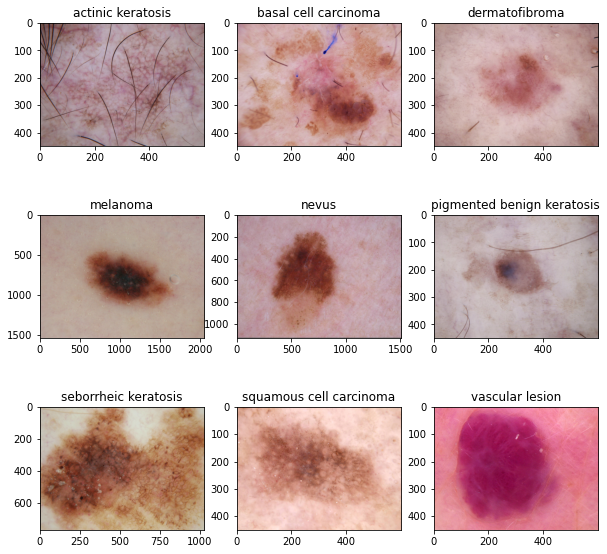

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3))
])
model.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation='relu', input_shape=(180,180,32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(num_classes,activation="softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 112ms/step - loss: 1.9862 - accuracy: 0.2734 - val_loss: 1.6380 - val_accuracy: 0.4094
Epoch 2/20
56/56 [==============================] - 5s 88ms/step - loss: 1.6246 - accuracy: 0.4135 - val_loss: 1.4629 - val_accuracy: 0.4899
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 1.4313 - accuracy: 0.4900 - val_loss: 1.4330 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.3478 - accuracy: 0.5190 - val_loss: 1.4046 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 5s 87ms/step - loss: 1.2215 - accuracy: 0.5631 - val_loss: 1.5120 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 5s 88ms/step - loss: 1.1653 - accuracy: 0.5837 - val_loss: 1.4212 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 5s 95ms/step - loss: 1.0847 - accuracy: 0.6133 - val_loss: 1.5132 - val_accuracy: 0.5056
Epoch 8/20


### Visualizing training results

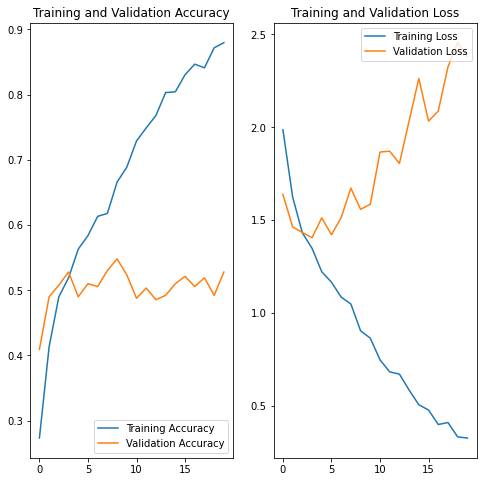

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- The model clearly has been overfit as we can see with the loss and with the accuracy which has more difference.
- Maybe if we add dropout layer there might be some improvement in the model.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augment = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3),fill_mode='reflect')
])

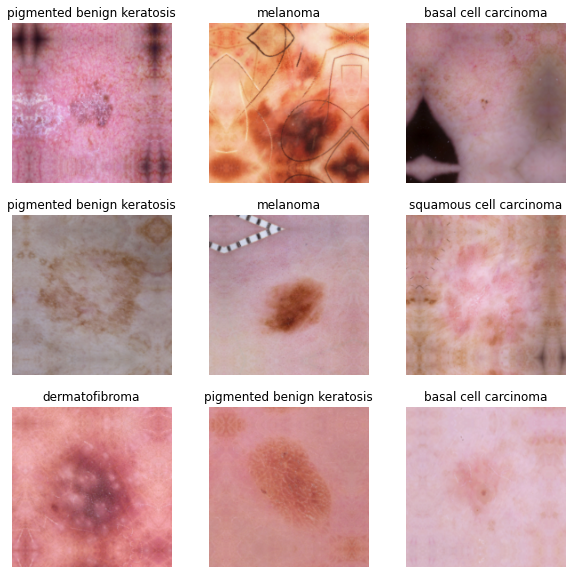

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(data_augment(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([data_augment,
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3))
])
model.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation='relu', input_shape=(180,180,32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(num_classes,activation="softmax"))

### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 140ms/step - loss: 2.1166 - accuracy: 0.2444 - val_loss: 1.9594 - val_accuracy: 0.3087
Epoch 2/20
56/56 [==============================] - 8s 139ms/step - loss: 1.7596 - accuracy: 0.3683 - val_loss: 1.6626 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 7s 133ms/step - loss: 1.5858 - accuracy: 0.4408 - val_loss: 1.6406 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 8s 137ms/step - loss: 1.5441 - accuracy: 0.4509 - val_loss: 1.4428 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 7s 133ms/step - loss: 1.4613 - accuracy: 0.4905 - val_loss: 1.5385 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 7s 134ms/step - loss: 1.4144 - accuracy: 0.5084 - val_loss: 1.4113 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 8s 134ms/step - loss: 1.3997 - accuracy: 0.5050 - val_loss: 1.4841 - val_accuracy: 0.4832
Epoch

### Visualizing the results

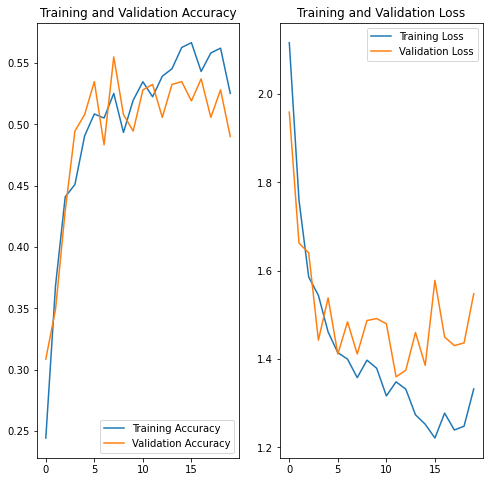

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- There has not been much change in the accuracy , but the overfitting has been reduced tremendously. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
path_list = []
lesion_list = []
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dictionary_original = dict(zip(path_list, lesion_list))
train_img_df = pd.DataFrame(list(dictionary_original.items()), columns=['Path','Label'])
train_img_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


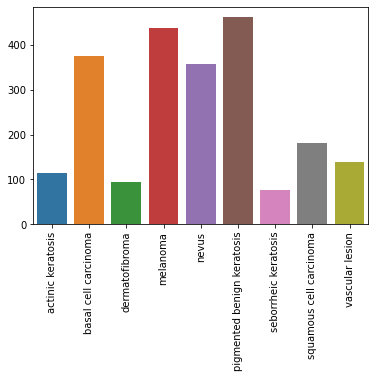

In [23]:
count = []
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
sns.barplot(class_names,count)
plt.xticks(rotation=90)
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E970E31DC0>: 100%|█| 500/500 [00:04<00:00, 103.63 Samples


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E96FC36430>: 100%|█| 500/500 [00:04<00:00, 102.92 Samples


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E970AE3AF0>: 100%|█| 500/500 [00:04<00:


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1E9703E7B50>: 100%|█| 500/500 [00:30<00


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=962x723 at 0x1E9703E0430>: 100%|█| 500/500 [00:22<00:00, 22.20 Samples/


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E970ACA310>: 100%|█| 500/500 [00:04<00:


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E9AD17D3D0>: 100%|█| 500/500 [00:11<00:00, 43.70 Samples


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E96FC7E370>: 100%|█| 500/500 [00:04<00:00, 108.05 Samples


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E9703D0E20>: 100%|█| 500/500 [00:04<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3dfedfa6-081d-4e2a-bac3-9d90dcc17d6b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9e7fa759-2154-40be-9c9d-0fdf77439812.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_2c2bc971-ee60-4dea-8e9c-f95ae9526bd2.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_31a96264-5daf-409a-b8d6-d2fca1199a83.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_7f47e0e1-5ed0-4cad-af3b-18468e877ba3.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = train_img_df.append(df2)

In [31]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [32]:
new_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
4495,Skin cancer ISIC The International Skin Imagin...,vascular lesion
4496,Skin cancer ISIC The International Skin Imagin...,vascular lesion
4497,Skin cancer ISIC The International Skin Imagin...,vascular lesion
4498,Skin cancer ISIC The International Skin Imagin...,vascular lesion


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [40]:
## your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3))
])
model.add(Conv2D(filters=32, kernel_size=(3,3),padding='Same',activation='relu', input_shape=(180,180,32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.55))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.30))
model.add(Dense(num_classes,activation="softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [42]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 18s 100ms/step - loss: 1.8585 - accuracy: 0.3253 - val_loss: 1.6008 - val_accuracy: 0.4001
Epoch 2/20
169/169 [==============================] - 21s 113ms/step - loss: 1.4638 - accuracy: 0.4551 - val_loss: 1.7178 - val_accuracy: 0.3838
Epoch 3/20
169/169 [==============================] - 19s 112ms/step - loss: 1.3681 - accuracy: 0.4959 - val_loss: 1.2499 - val_accuracy: 0.5442
Epoch 4/20
169/169 [==============================] - 19s 111ms/step - loss: 1.2759 - accuracy: 0.5295 - val_loss: 1.3066 - val_accuracy: 0.4959
Epoch 5/20
169/169 [==============================] - 18s 105ms/step - loss: 1.1964 - accuracy: 0.5558 - val_loss: 1.1419 - val_accuracy: 0.5843
Epoch 6/20
169/169 [==============================] - 18s 104ms/step - loss: 1.1279 - accuracy: 0.5896 - val_loss: 1.1624 - val_accuracy: 0.5330
Epoch 7/20
169/169 [==============================] - 17s 99ms/step - loss: 1.0273 - accuracy: 0.6233 - val_loss: 1.2580 - val_acc

#### **Todo:**  Visualize the model results

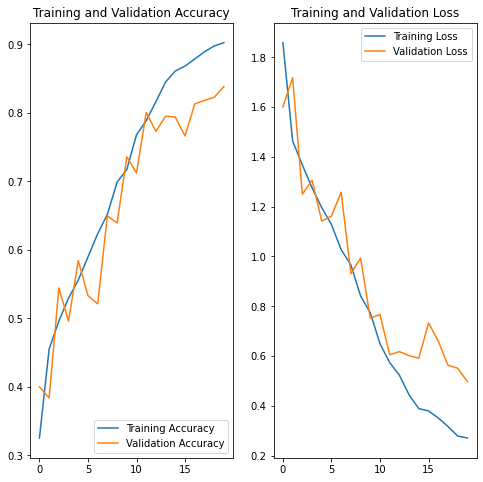

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- The overfitting has been reduced and the class rebalance has helped us in improving the accuracy of the model.